# Semi-supervised Community Detection using Graph Neural Networks

In this tutorial, you will learn:

* Formulate the community detection problem as a semi-supervised node classification task.
* Build a GraphSAGE model and a GraphConv Model, a popular Graph Neural Network architecture 
* Train the model and understand the result.

In [13]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools

## Community detection as node classification

The study of community structure in graphs has a long history. Many proposed methods are *unsupervised* , where the model predicts the community labels only by connectivity. 

In this tutorial, we apply Kipf's setting to the Zachery's Karate Club network to predict the community membership, where only the labels of a few nodes are used.

In [14]:
from tutorial_utils import load_zachery

# ----------- 0. load graph -------------- #
g = load_zachery()
print(g)

Graph(num_nodes=34, num_edges=156,
      ndata_schemes={'club': Scheme(shape=(), dtype=torch.int64), 'club_onehot': Scheme(shape=(2,), dtype=torch.int64)}
      edata_schemes={})


In [15]:
# ----------- 1. node features -------------- #
node_embed = nn.Embedding(g.number_of_nodes(), 5)  # Every node has an embedding of size 5.
inputs = node_embed.weight                         # Use the embedding weight as the node features.
print(inputs)

Parameter containing:
tensor([[-0.6297, -0.7211, -0.3253, -1.4820, -1.3983],
        [ 0.6145,  1.0914,  0.0860, -2.0085,  1.9902],
        [-0.9325, -1.0259, -1.5023,  0.2462, -1.3877],
        [-0.2723,  1.0107, -0.9979,  0.0081, -0.7988],
        [ 0.2982, -1.1246,  0.1310, -0.1942, -0.2305],
        [ 0.5466, -0.2568,  0.6038, -0.4615,  1.3579],
        [ 0.3303, -0.6089,  0.7706, -0.5897, -0.6836],
        [ 2.1392,  0.6236,  0.0526, -0.5386, -2.0230],
        [-0.6140, -1.0698,  0.2490,  0.3770, -1.3618],
        [ 0.6151,  1.6254,  2.0010,  1.7453, -0.4686],
        [-1.1599,  0.6423, -0.2694, -0.7305,  1.1891],
        [-1.9849, -1.7242, -1.2071, -1.0981, -0.6769],
        [-1.4763,  1.2578, -0.3490,  0.3247, -0.6603],
        [ 0.0162, -0.6521, -1.4029,  0.1567,  1.8986],
        [ 0.2861, -0.1446, -0.1386, -2.1708,  0.1460],
        [ 0.2611, -1.1378, -1.3154,  0.8869, -0.9575],
        [ 0.8966, -0.5012,  0.1599,  0.1635,  1.1530],
        [ 0.6891, -0.5617,  0.9163, -0.0409

The community label is stored in the `'club'` node feature (0 for instructor, 1 for club president). Only nodes [0,1,3,10,12,16,18,22,28,33] are labeled.

In [16]:
labels = g.ndata['club']
labeled_nodes = [0,1,3,10,12,16,18,22,28,33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])


In [17]:
from dgl.nn import GraphConv as SAGEConv

# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'none')
        self.conv2 = SAGEConv(h_feats, num_classes, 'none')
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
    
# Create the model with given dimensions 
net = GraphSAGE(5, 20, 2)

In [18]:
# ----------- 3. set up loss and optimizer -------------- #
# in this case, loss will in training loop
optimizer = torch.optim.Adam(itertools.chain(net.parameters(), node_embed.parameters()), lr=0.01)

# ----------- 4. training -------------------------------- #
all_logits = []
for e in range(100):
    # forward
    logits = net(g, inputs)
    
    # compute cross entropy loss
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labeled_nodes], labels[labeled_nodes])
    
    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    all_logits.append(logits.detach())
    
    if e % 5 == 0:
        print('In epoch {}, loss: {}'.format(e, loss))

In epoch 0, loss: 7.349887847900391
In epoch 5, loss: 0.05543466657400131
In epoch 10, loss: 0.24144777655601501
In epoch 15, loss: 0.014259003102779388
In epoch 20, loss: 0.0021149914246052504
In epoch 25, loss: 0.0005469805328175426
In epoch 30, loss: 0.00022121737129054964
In epoch 35, loss: 0.0001296358386753127
In epoch 40, loss: 9.176519233733416e-05
In epoch 45, loss: 7.362654287135229e-05
In epoch 50, loss: 6.386554014170542e-05
In epoch 55, loss: 5.8204248489346355e-05
In epoch 60, loss: 5.47597483091522e-05
In epoch 65, loss: 5.2530936955008656e-05
In epoch 70, loss: 5.102915383758955e-05
In epoch 75, loss: 4.9920694436877966e-05
In epoch 80, loss: 4.908636765321717e-05
In epoch 85, loss: 4.838314634980634e-05
In epoch 90, loss: 4.7763354814378545e-05
In epoch 95, loss: 4.7203164285747334e-05


In [19]:
# ----------- 5. check results ------------------------ #
pred = torch.argmax(logits, axis=1)
print('Accuracy', (pred == labels).sum().item() / len(pred))

Accuracy 0.9705882352941176


In [12]:
# A bit of setup, just ignore this cell
import matplotlib.pyplot as plt

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

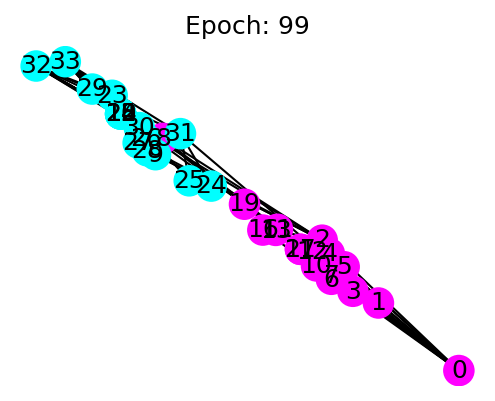

In [61]:
# Visualize the node classification using the logits output. Requires ffmpeg.
import networkx as nx
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_logits[i].numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)

ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)
HTML(ani.to_html5_video())